# Topic Modelling with BERTopic 🎯

BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. [See documentation here](https://maartengr.github.io/BERTopic/index.html).

The pipeline of BERTopic can be broken down into 6 steps. Text data is initially converted into embeddings that capture the contextual relationships between words. These embeddings, derived from a pre-trained BERT language model, encode rich semantic information about the text.

Next, the embeddings undergo dimensionality reduction, a process that helps in clustering similar documents more efficiently while preserving their semantic structure. Following dimensionality reduction, the embeddings are clustered using an algorithm such as HDBSCAN, which groups documents into topics based on their semantic similarity.

Each cluster or group of documents represents a potential topic, allowing for the extraction of meaningful themes from the text data. Finally, BERTopic employs a class-based TF-IDF metric to identify the most representative words of each topic, thereby creating a descriptive label for each identified topic.

By utilising advanced techniques in natural language processing and machine learning, BERTopic offers a more nuanced and contextually relevant approach to topic modeling compared to traditional methods. This enables users to extract deeper insights and uncover hidden patterns within their text datasets.

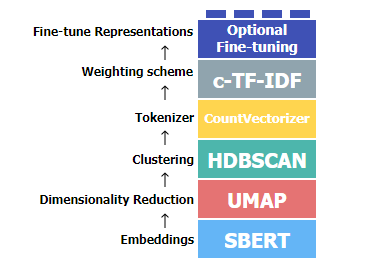...

The graphic above is used to illustrate the modularity of BERTopic and is helpful to communicate the sequence of steps taken. Because the pipeline is modular by design, the actual methods and algorithms used can be adapted to the current state-of-the-art.

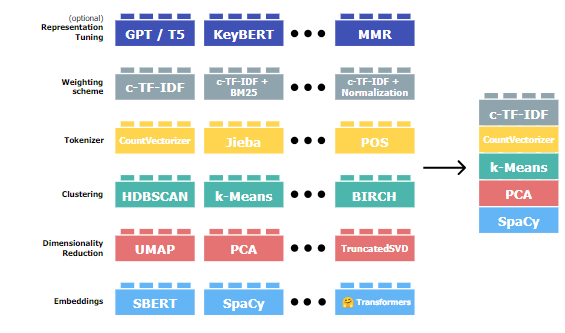


## Setup

Install and import neccessary libraries.

In [2]:
%%capture
!pip install bertopic openai sentence-transformers langchain pymupdf

In [3]:
# Standard library imports
from pathlib import Path
import re
import requests
from typing import List
import textwrap
from urllib.parse import urlparse

import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from google.colab import userdata
from bertopic import BERTopic
from langchain_community.document_loaders import PyMuPDFLoader
from tqdm import tqdm

# Download NLTK tokeniser
nltk.download('punkt')

In [23]:
# Function to download a single file
def download_file(url: str, file_path: Path) -> None:
    """
    Downloads a file from the specified URL.

    Args:
        * url (`str`): URL of the file to download.
        * file_path (`Path`): The Path object for the file where it will be saved.

    Downloads the file from the URL into the specified file path.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises HTTPError if the HTTP request returned an unsuccessful status code

        with open(file_path, "wb") as file:
            file.write(response.content)

    except requests.HTTPError as e:
        print(f"HTTP Error occurred: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Function to extract text from a single PDF file
def extract_content_from_pdf(pdf_path: Path) -> str:
    """
    Extracts text from a PDF file.

    Args:
        * pdf_path (`Path`): Path to the PDF file.

    Returns:
        * `str`: Text extracted from the PDF.
    """
    return PyMuPDFLoader(str(pdf_path)).load()

def extract_text_from_doc(doc)->str:
  """
  Extracts text content from a document object.

  Args:
    * doc: Document object

  Returns:
    * combined_text (`str`): a single string of the extracted text.
  """
  # Initialise an empty string to store the combined page content
  combined_text = ""
  # Iterate over each document in the list
  for document in document_content:
      # Extract the page content from the document
      page_content = document.page_content
      # Append the page content to the combined text
      combined_text += page_content.strip() + "\n"  # Add a newline for separation if needed

  return combined_text

In [26]:
# URL of the PDF document to download
url = "https://www.bis.org/bcbs/publ/d424_hlsummary.pdf"
# Define the file path to save the downloaded PDF
pdf_path = Path.cwd() / "document.pdf"

# Download the PDF document
download_file(url, pdf_path)
# Extract content from the downloaded PDF
document_content = extract_content_from_pdf(pdf_path)
# Extract text from the downloaded PDF
combined_text = extract_text_from_doc(document_content)
# Sentencise the document
sentences = sent_tokenize(combined_text)

## Data

For this example, upload a csv of an extracted document (from KSE app)

In [ ]:
pra_2023 = pd.read_csv("pra-processed-text.csv")
sentences = pra_2023['Sentence'].tolist()

Then we will tokenise each sentence

In [ ]:
nltk.download('punkt')

tokenised_sentences = []
# Tokenise each sentence in the list
for sentence in sentences:
    tokenised_sentence = sent_tokenize(sentence)
    # Add the tokenised sentence to the list of tokenised sentences
    tokenised_sentences.append(tokenised_sentence)

## Create sentence embeddings

Create sentence embeddings from the document abstracts

In [27]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(sentences, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

## Dimensionality reduction

To reduce the size of the embeddings we can use a dimensionality reduction technique such as UMAP (Uniform Manifold Approximation & Projection).



In [28]:
"""
UMAP parameters

* n_neighbours: how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. As n_neighbors increases further more and more focus in placed on the overall structure of the data. This results in, with n_neighbors=200, a plot where the overall structure is well captured, but at the loss of some of the finer local structure.
* n_components: number of dimensions of the reduced dimension space.
* min_dist: minimum distance points are allowed to be in the reduced dimensional space. Low values will result in clumpier embeddings, useful for clustering.
* metric: method for computing distance between points
* random_state: by default, UMAP shows stochastic behaviour but we can avoid this by specifying the random state.
"""

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

## Clustering

In [29]:
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

## Tokeniser

In [30]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

## Create topics

In creating the topics, we can finetune the embedding model to extract different representations of topics. Some of these representation models are described below:

* KeyBERT - finds subphrases in a document that best represent the document itself, using BERT-embeddings and cosine similarity.
* Part-of-Speech (POS) - generates new candidate keywords for each topic based on existing documents that contain a keyword.
* Marginal Maximal Relevance (MMR) - aims to maximise diversity of keywords and phrases by considering the similarity of keywords and phrases within a document.
* OpenAI GPT-4 - using prompting to produce a short topic description based on aleady identified key words and phrases.

In [31]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-4
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
I have a topic that is described by the following keywords: [KEYWORDS]. These keywords have been extracted from key sentences within a financial document.

Based on the information above, extract a short but highly descriptive topic label of at most 6 words. Make sure it is in the following format:
topic: <topic label>
"""
client = openai.OpenAI(api_key=userdata.get("OpenAI2"))
openai_model = OpenAI(client, model="gpt-4", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "OpenAI": openai_model,
    "MMR": mmr_model,
    "POS": pos_model
}

In [32]:
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=20,
  verbose=True,
  calculate_probabilities=True
)

topics, probs = topic_model.fit_transform(sentences, embeddings)

2024-04-25 16:07:31,334 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-25 16:07:40,839 - BERTopic - Dimensionality - Completed ✓
2024-04-25 16:07:40,841 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-25 16:07:40,871 - BERTopic - Cluster - Completed ✓
2024-04-25 16:07:40,887 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 3/3 [00:03<00:00,  1.07s/it]
2024-04-25 16:07:47,921 - BERTopic - Representation - Completed ✓


In [33]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs
0,-1,14,-1_january_2022_january 2022_sib,"[january, 2022, january 2022, sib, floor, rwas...","[tier leverage, ratio sib, weighted sib, lever...",[Basel III Reforms & Output Floor Implementation],"[january 2022, sib, rwas, requirements, levera...","[floor, requirements, requirement, ratio, outp...",[A G-SIB \nthat does not meet one of these req...
1,0,100,0_risk_approach_basel_standardised,"[risk, approach, basel, standardised, capital,...","[credit risk, risk framework, capital requirem...",[Basel III Reforms on Risk Approaches],"[risk, capital, banks, leverage, basel iii, st...","[risk, approach, standardised, capital, credit...",[ISBN 978-92-9259-118-2 (online)\nHigh-level s...
2,1,17,1_irb_irb approaches_floors_approaches,"[irb, irb approaches, floors, approaches, clas...","[irb approaches, irb approach, revised irb, ad...",[IRB Approaches Revision and Asset Classes],"[irb, irb approaches, floors, irb approach, as...","[floors, approaches, classes, default, asset, ...",[These include PD floors for both the F-IRB an...


In [ ]:
# Extract OpenAI topic labels
df = topic_model.get_topic_info()
df['OpenAI']

0       [PRA's Financial Risk Management Policies 2022]
1                 [Prudential Regulation in UK Banking]
2           [Comprehensive Financial Document Analysis]
3                   [Financial Document Pages Analysis]
4              [Senior Leadership and Financial Trends]
5                [PRA Review and Business Plan 2022/23]
6           [PRC Annual Reports & Regulatory Functions]
7      [PRA's Risk Management and Supervisory Approach]
8                [PRA's Duty for Effective Competition]
9     [Financial Services Regulatory Initiatives Forum]
10    [UK Banking Ring-Fencing and Proprietary Trading]
11    [Financial Resilience Amid Ukraine Invasion Sh...
12              [TSB Bank's FCA/PRA Fines for Failures]
13                    [Solvency II Reviews and Reforms]
14    [Supervisory Risk and Deposit Takers Supervision]
15       [Narrowing SA and IRB Capital Requirement Gap]
16              [Strong and Simple Framework for Banks]
17      [External Members' Terms and Tenures 202

## Topic distribution

In [ ]:
topic_distr, _ = topic_model.approximate_distribution(sentences, window=8, stride=4)

100%|██████████| 2/2 [00:00<00:00, 12.71it/s]


In [ ]:
# Visualise topic distribution for specific sentences
sentence_id = 75
print(sentences[sentence_id])
topic_model.visualize_distribution(topic_distr[sentence_id])

We set out, in a discussion paper (DP) in September 2022, the PRA's proposed approach to dispensing our new rule-making role and our vision to be a strong, accountable, responsive, and accessible rule-maker


IndexError: index 75 is out of bounds for axis 0 with size 1

In [ ]:
# Visualise on the token level
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(sentences[sentence_id], calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(sentences[sentence_id], topic_token_distr[0])
df

100%|██████████| 1/1 [00:00<00:00, 209.76it/s]


,We,set,out,in,discussion,paper,DP,in,September,2022,the,PRA,proposed,approach,to,dispensing,our,new,rule,making,role,and,our,vision,to,be,strong,accountable,responsive,and,accessible,rule,maker
4_2022 23_23_2022_reporting,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.254,0.401,0.401,0.295,0.147,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_supervisory_approach_risk_supervision,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.215,0.359,0.601,0.494,0.387,0.243,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14_irb_sa_risk_gap,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.134,0.264,0.264,0.264,0.130,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
15_strong simple_simple_small_simple framework,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.116,0.116,0.116,0.217,0.102,0.102,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.194,0.296,0.397,0.498,0.303,0.202,0.101,0.000,0.000,0.000
16_member_term_external_executive,0.000,0.000,0.000,0.000,0.000,0.000,0.139,0.307,0.447,0.447,0.308,0.140,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21_included_abbreviations_stand_statements,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.285,0.432,0.432,0.432,0.147,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Visualisation

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_hierarchy()